# Seismic CropBatch tutorial

Welcome! This notebook shows how to use `SeismicCropBatch` to load data from cubes, create segmentation masks from labels, and more!

In [1]:
# Necessary modules
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

from glob import glob

sys.path.append('..')
from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow import D, P, R, L
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset



#### First of all, we create `SeismicCubeset`
To learn more what it is all about, check out our previous tutorial

In [2]:
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
path_data_1 = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'
path_data_2 = '/notebooks/SEISMIC_DATA/CUBE_4/R_cube.hdf5'

path_pc_saved = '/notebooks/SEISMIC_DATA/SAVED/DEMO/point_clouds.dill'

dsi = FilesIndex(path=[path_data_0, path_data_1, path_data_2], no_ext=True)
ds = SeismicCubeset(dsi)

ds = (ds.load_geometries()
        .load_point_clouds(load_from = path_pc_saved)
        .load_labels()
        .load_samplers()
      )
# ~80 seconds

#### Create batch

* First action, `load_component`, creates references to geometries and labels in instance of `SeismicCropBatch`. That is done for convinience and ease of access of these entities.

* Then we use `crop`. It creates positions to cut crops of desired shape from cubes. Note that it does not load anything from disk: only positions are created.

* Heavy lifting of disk I/O is performed by `load_cubes`, that takes positions (created by `crop`) and actually gets data from cube.

* `create_masks` creates segmentation mask of the same size as cutted crop from `labels` dictionary.

In [3]:
demo_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(ds.sampler.sample, 64), shape=[3, 512, 512])
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 ) << ds

demo_batch = demo_pipeline.next_batch(3, n_epochs=None)

#### Check contents of `data_crops` and `mask_crops` components of batch:

Repaired_cube


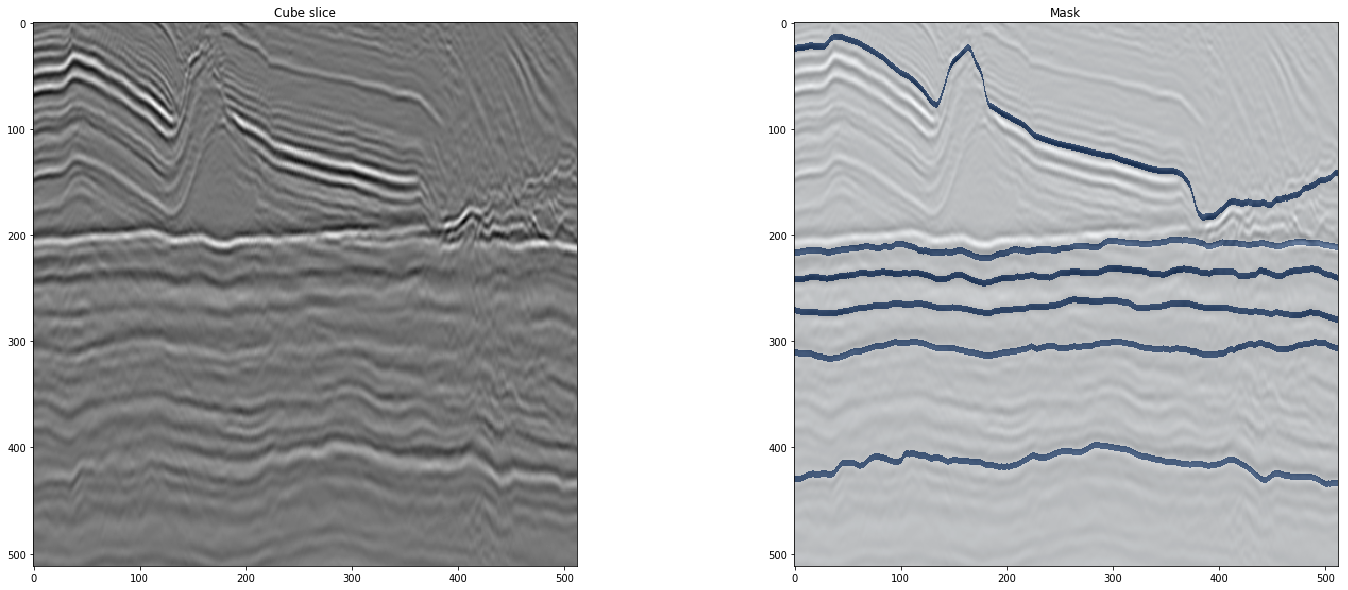

Repaired_cube


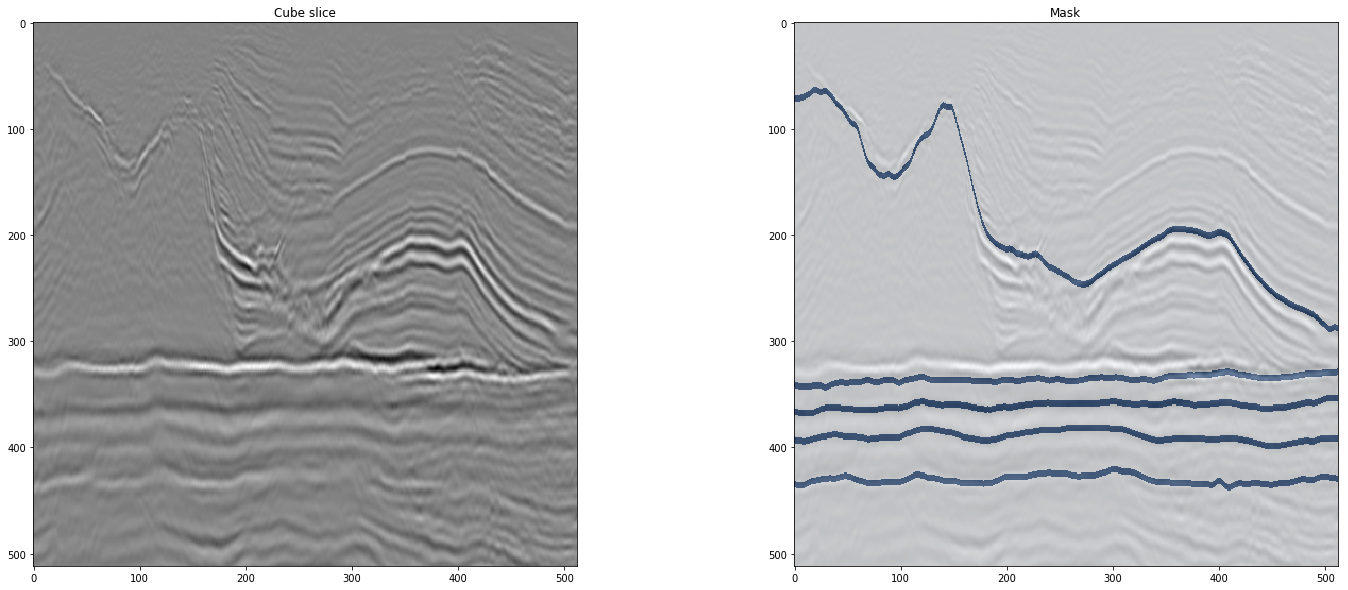

P_cube


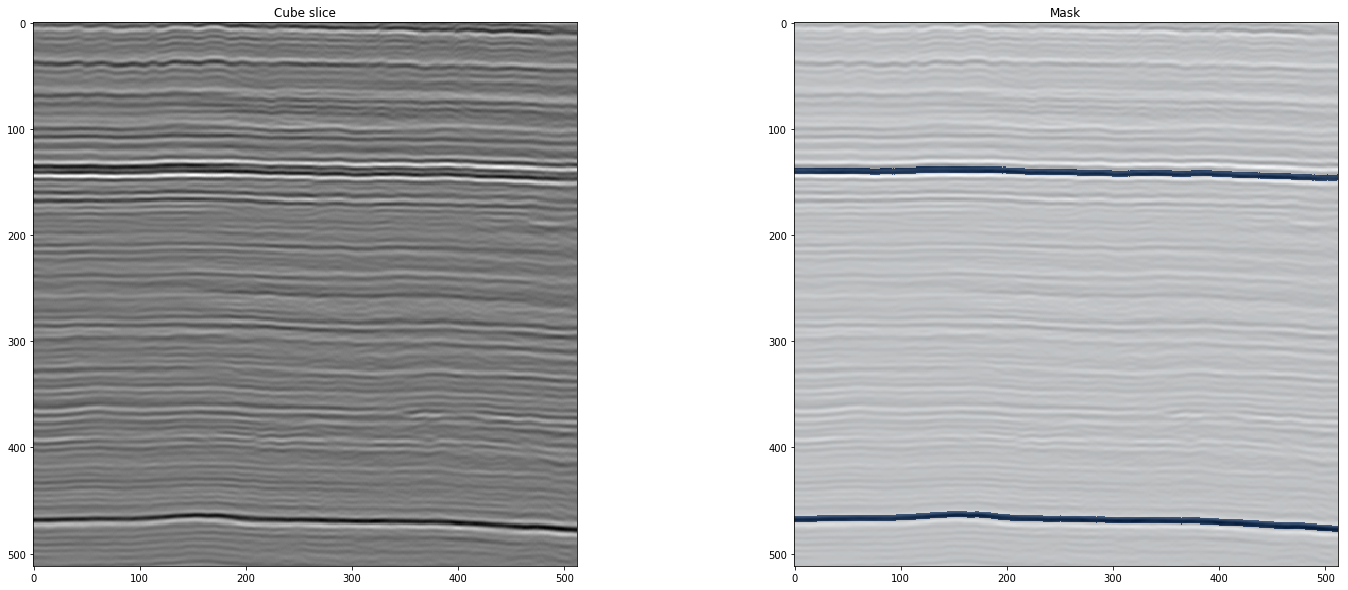

Repaired_cube


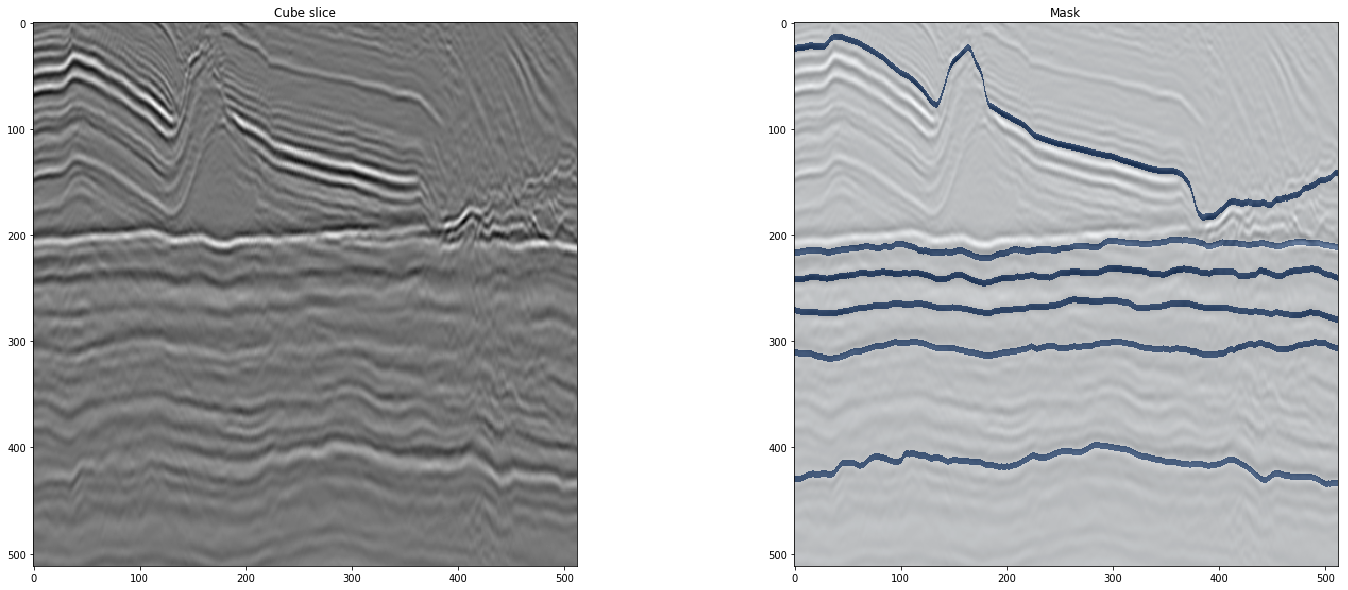

Repaired_cube


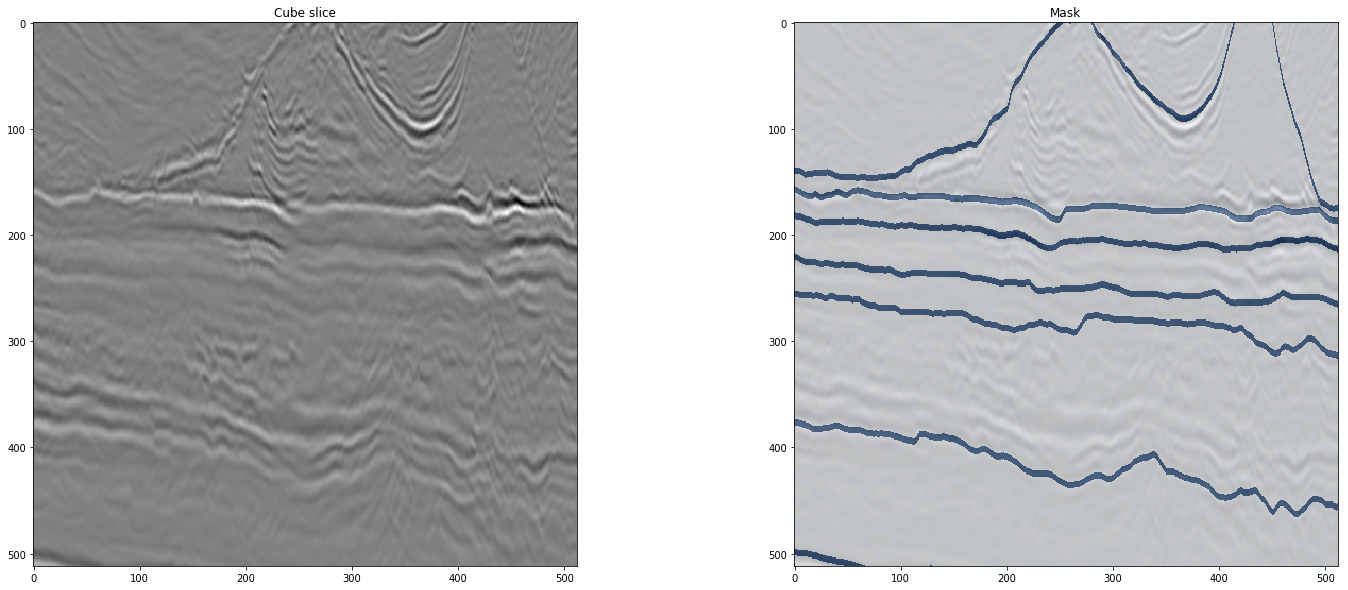

In [4]:
for cube in np.random.choice(16, 5):
    print(demo_batch.indices[cube][:-10])
    iline = 0
    
    img = demo_batch.data_crops[cube][iline, :, :].T
    mask = demo_batch.mask_crops[cube][iline, :, :].T
    
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Cube slice')
    
    ax[1].imshow(mask, cmap="Blues")
    ax[1].imshow(img, cmap="gray", alpha=0.5)
    ax[1].imshow(mask, cmap="Blues", alpha=0.1)
    ax[1].set_title('Mask')
   
    plt.show()

#### Lets add some data augmentations:
* `rotate_axis.` By default, `crop`, `load_cubes`, `create_mask` work in [iline, xline, h] format. That might be inconvenient to work with, as most of our models percieve that 3D entity as 2D entity with multiple channels. This action makes order [xline, h, iline].
* `add_axis.` Again, if model works with 3D entity via 2D convolutions, it needs one additional dimension added to the output in order to correctly compute loss between NN-output and reference segmentation mask.
* `scale.` As different cubes have different ranges of possible values, it is usually a good idea to transform each of them to [0, 1] range. Under the hood, minimum and maximum values for each cube are used.
* `additive_noise`, `multiplicative_noise.` Modify each entry in `src` by adding zero-mean noise or multiplying by values with mean at 1.

#### All of the next actions are applied to the first two axes, so `rotate_axis` is what you want to do before them!
* `rotate`, `scale_2d.` Rotate image around its center, zoom in or zoom out of it. 
* `cutout_2d`. Zero-out patches of first two axes.
* `affine_transform`, `perspective_transform.` Change basis to move 3 (4 in case of perspective transform) points to different location. 
* `elastic_transform.` Slightly jitter the indexing grid of the first two axes of `src`. 
* `bandwidth_filter.` Keep only desired range of frequences.

In [5]:
demo_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(ds.sampler.sample, 64), shape=[3, 512, 512])
                 .load_cubes(fmt='h5py', dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .scale(mode='normalize', src='data_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
#                  .add_axis(src='mask_crops')
                 # Augmentations
                 .additive_noise(scale=0.01,
                                 src='data_crops',
                                 dst='data_crops_anoise')
                 .multiplicative_noise(scale=0.01,
                                       src='data_crops',
                                       dst='data_crops_mnoise')
                 .cutout_2d(patch_shape=P(R('uniform', 10, 20, size=2)), n=P(R('uniform', 10, 20)),
                            src='data_crops',
                            dst='data_crops_cutout')
                 .rotate(angle=30,
                         src=['data_crops', 'mask_crops'],
                         dst=['data_crops_rotate', 'mask_crops_rotate'])
                 .scale_2d(scale=2,
                           src=['data_crops', 'mask_crops'],
                           dst=['data_crops_scale', 'mask_crops_scale'])
                 .affine_transform(alpha_affine=P(R('uniform', 0, 30)),
                                   src=['data_crops', 'mask_crops'],
                                   dst=['data_crops_affine', 'mask_crops_affine'])
                 .perspective_transform(alpha_persp=P(R('uniform', 0, 30)),
                                        src=['data_crops', 'mask_crops'],
                                        dst=['data_crops_perspective', 'mask_crops_perspective'])
                 .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                    src=['data_crops', 'mask_crops'],
                                    dst=['data_crops_elastic', 'mask_crops_elastic'])
                 .bandwidth_filter(lowcut=0.09, highcut=0.5, fs=2,
                                   src='data_crops',
                                   dst='data_crops_bfilter')
                 ) << ds

demo_batch = demo_pipeline.next_batch(3, n_epochs=None)

Repaired_cube


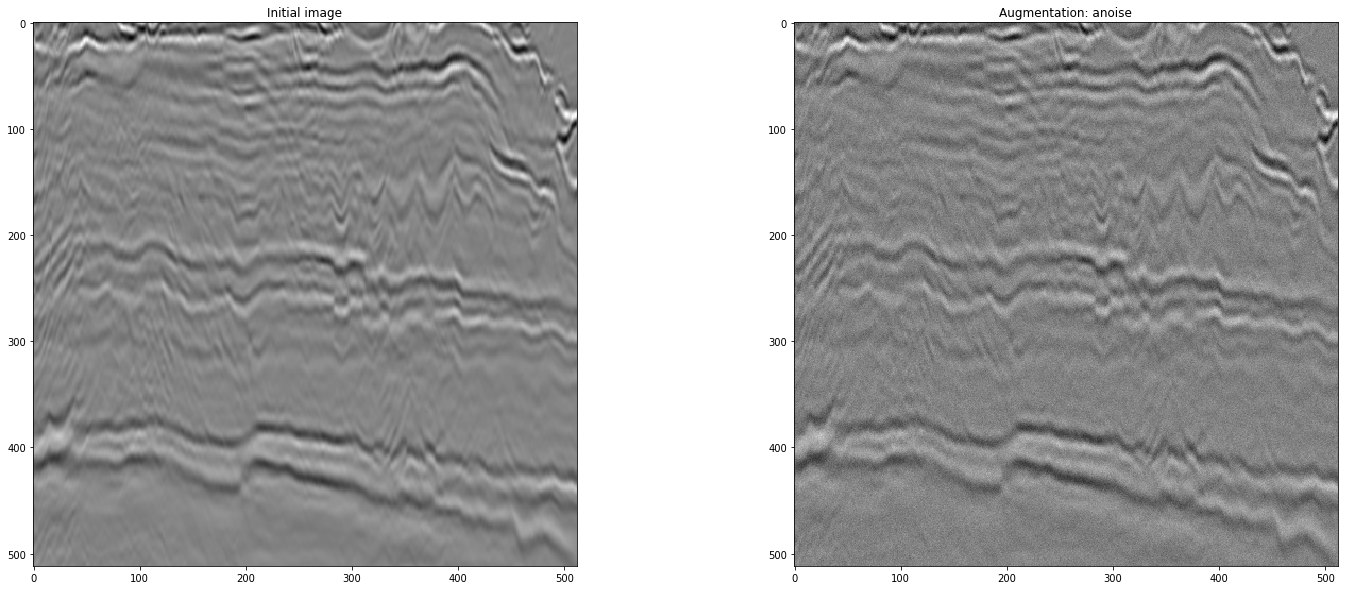

E_anon


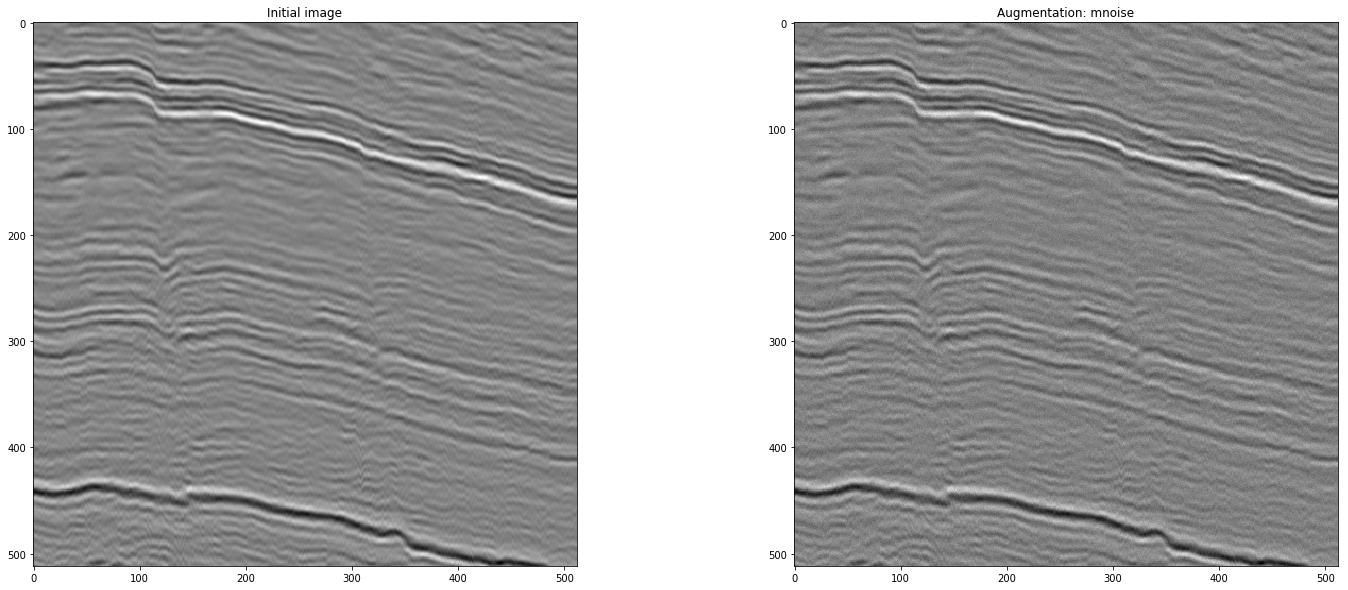

P_cube


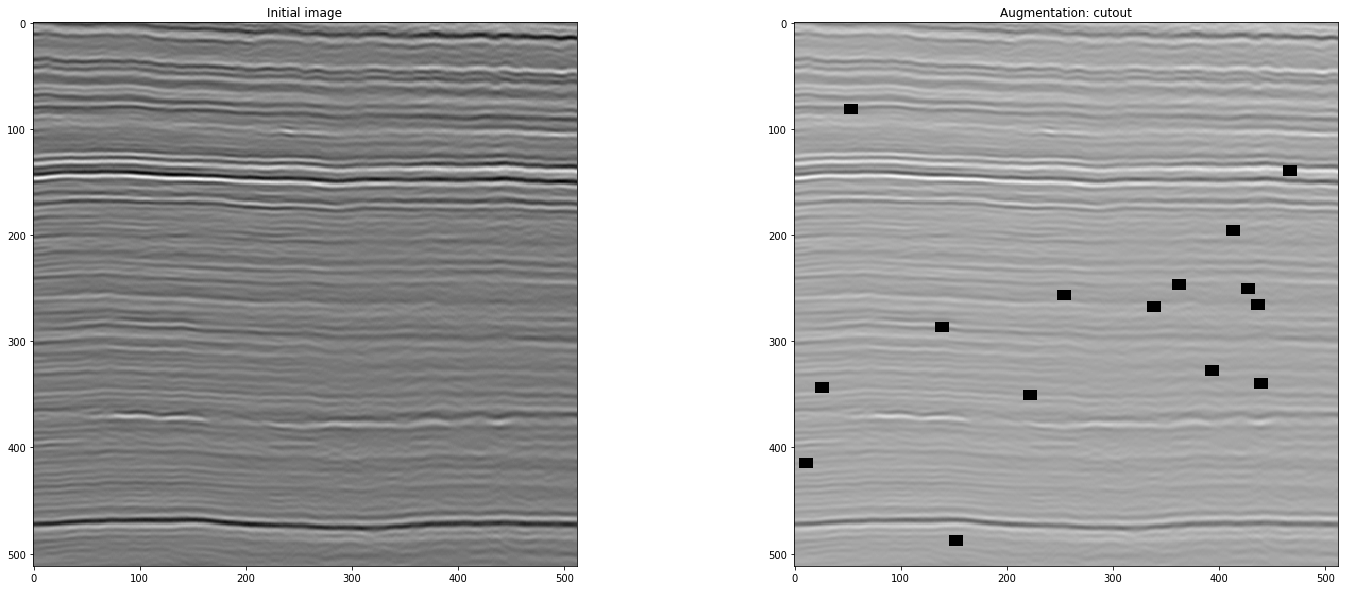

E_anon


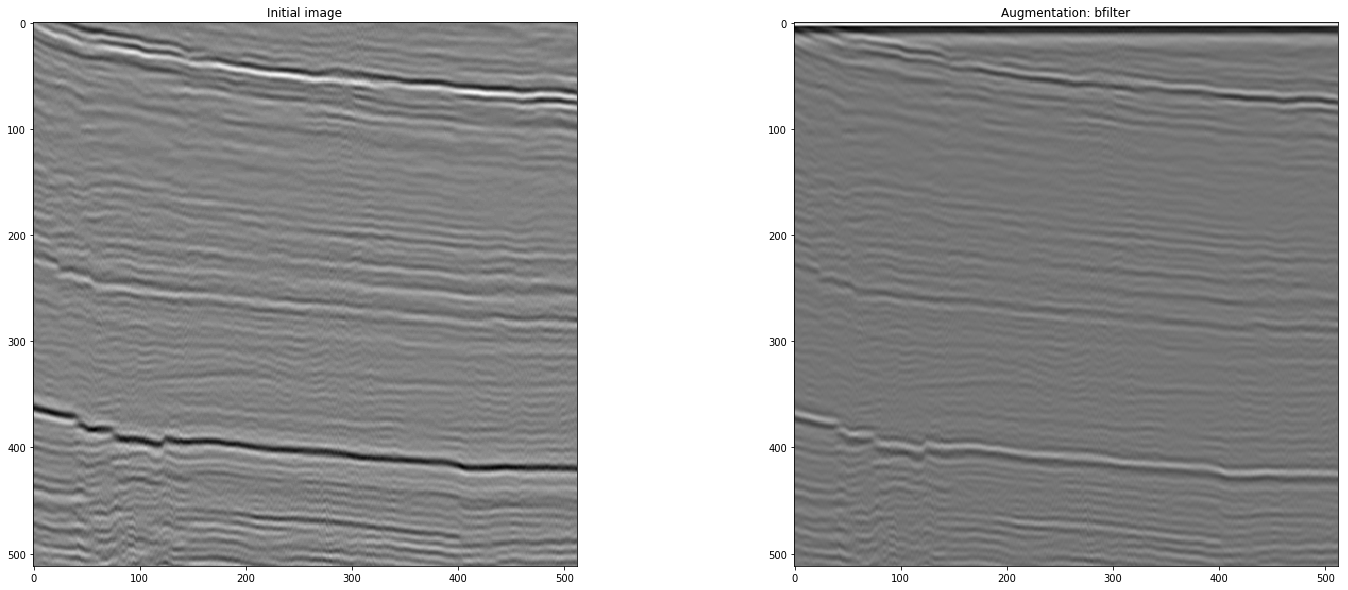

In [6]:
augs = ['anoise', 'mnoise', 'cutout', 'bfilter']

for aug in augs: 
    cube = np.random.randint(64)
    print(demo_batch.indices[cube][:-10])
    iline = 0
    
    data = getattr(demo_batch, 'data_crops')[cube][:, :, iline].T
    data_augmented = getattr(demo_batch, 'data_crops_' + aug)[cube][:, :, iline].T

    fig, ax = plt.subplots(1, 2, figsize=(25, 10))

    ax[0].imshow(data, cmap='gray')
    ax[0].set_title('Initial image')
    
    ax[1].imshow(data_augmented, cmap="gray")
    ax[1].set_title('Augmentation: {}'.format(aug))
    
    plt.show()
    

E_anon


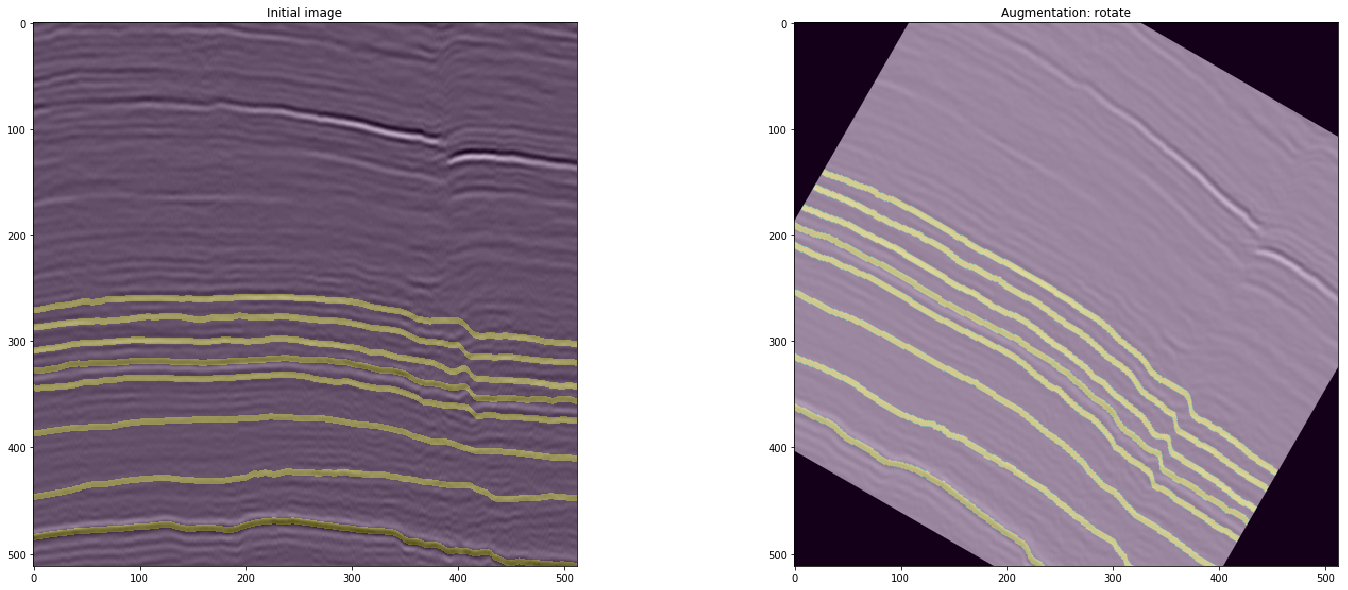

E_anon


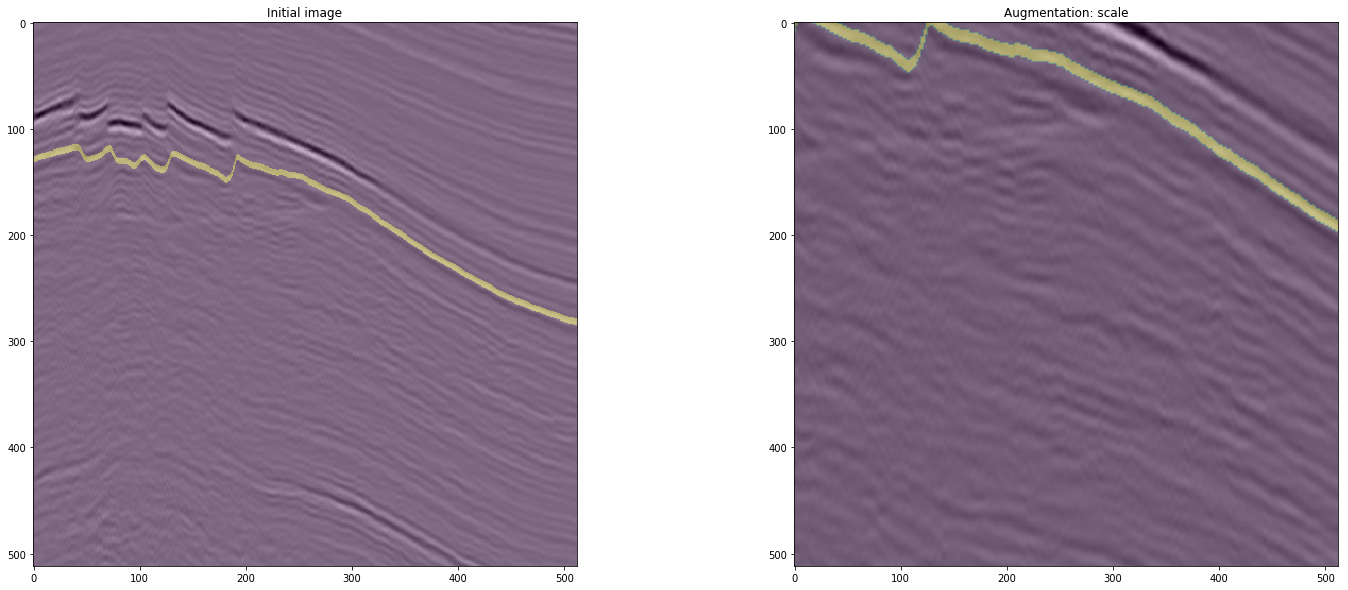

P_cube


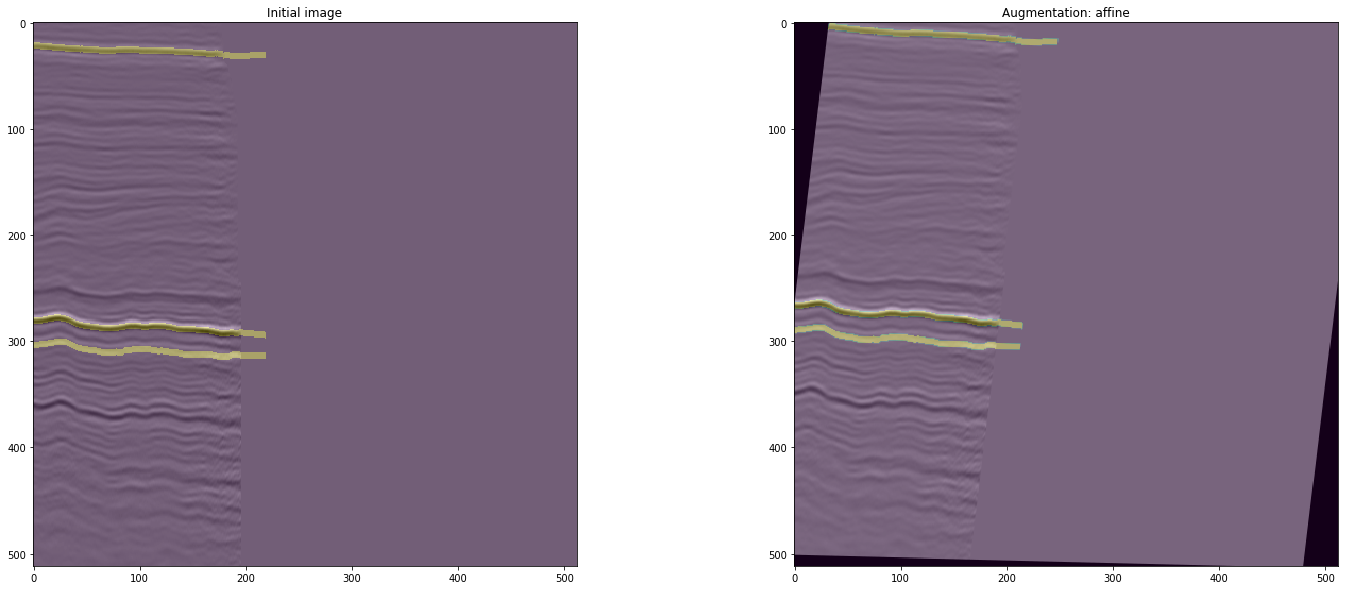

P_cube


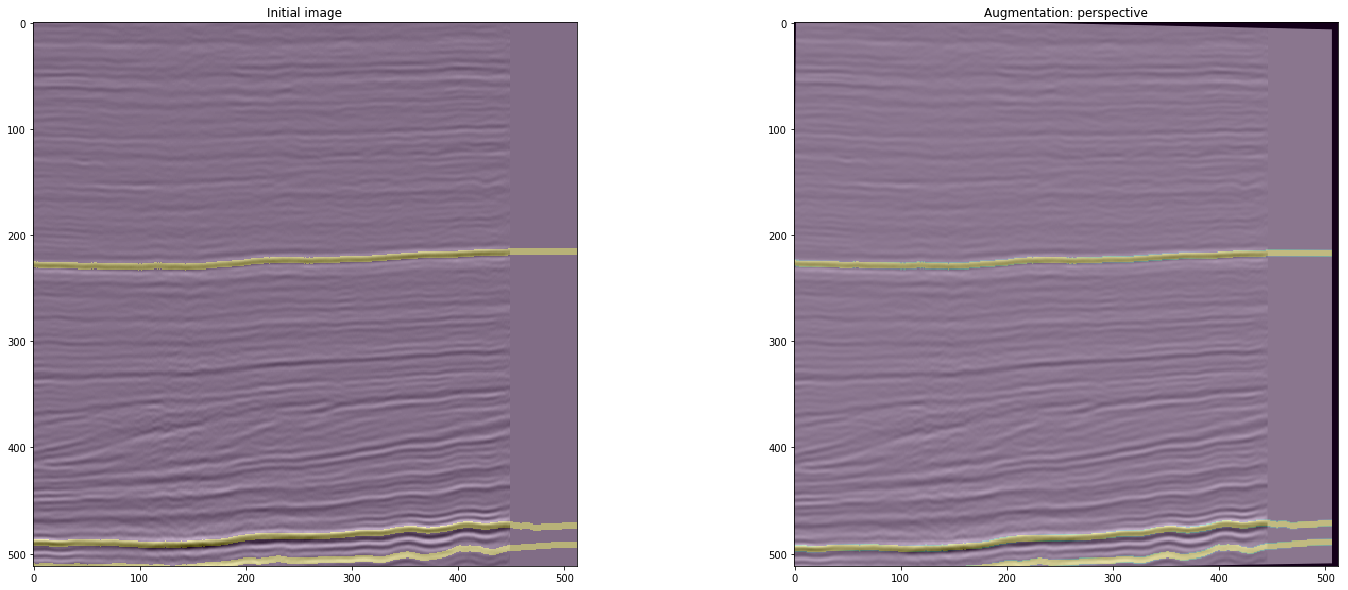

P_cube


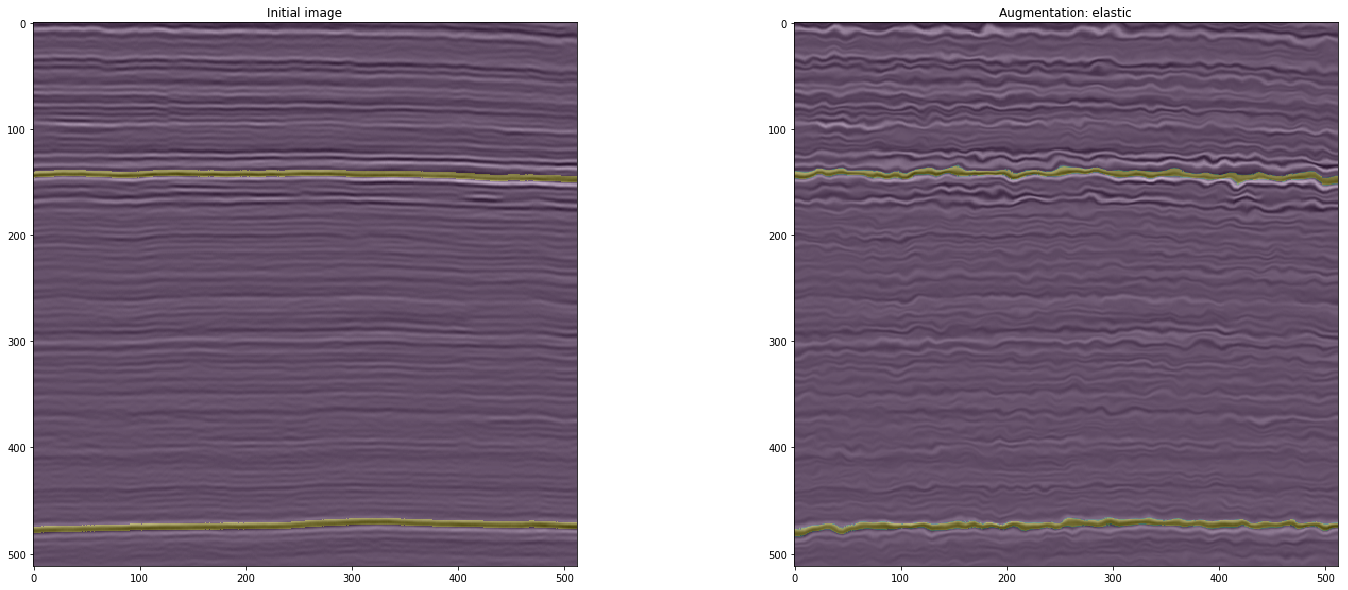

In [7]:
augs = ['rotate', 'scale', 'affine', 'perspective', 'elastic']

for aug in augs: 
    cube = np.random.randint(64)
    print(demo_batch.indices[cube][:-10])
    iline = 0
    
    data = getattr(demo_batch, 'data_crops')[cube][:, :, iline].T
    data_augmented = getattr(demo_batch, 'data_crops_' + aug)[cube][:, :, iline].T
    
    mask = getattr(demo_batch, 'mask_crops')[cube][:, :, iline].T
    mask_augmented =getattr(demo_batch, 'mask_crops_'+aug)[cube][:, :, iline].T
    
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))

    ax[0].imshow(data, cmap='gray')
    ax[0].imshow(mask, alpha=0.3)
    ax[0].set_title('Initial image')
    
    ax[1].imshow(data_augmented, cmap="gray")
    ax[1].imshow(mask_augmented, alpha=0.3)
    ax[1].set_title('Augmentation: {}'.format(aug))

    plt.show()